<a href="https://colab.research.google.com/github/BrMrtn/GoogleColab/blob/main/DLlab_05_1D_CNN_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Copyright
<pre>
Jelen forráskód a Budapesti Műszaki és Gazdaságtudományi Egyetemen
tartott "Deep Learning a gyakorlatban Python és LUA alapon" tantárgy segédanyagaként készült.

A tantárgy honlapja: http://smartlab.tmit.bme.hu/oktatas-deep-learning
Deep Learning kutatás: http://smartlab.tmit.bme.hu/deep-learning

A forráskódot GPLv3 licensz védi. Újrafelhasználás esetén lehetőség szerint kérejük az alábbi szerzőt értesíteni.

2023 (c) Gyires-Tóth Bálint (toth.b kukac tmit pont bme pont hu), Zainkó Csaba
</pre>

Jelen notebook egy példakódot mutat be egy dimenziós konvolúció alapú szekvenciális adat modellezésre. A példakód elsődlegesen az 1D konvolúcióra koncentrál, az általános megfontolások (standardizálás, min-max skálázás, early stopping, regularizáció, stb.) itt nem szerepelnek, de éles feladatokban szükségszerűek.

In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, Conv1D, MaxPooling1D
from tensorflow.keras.optimizers import SGD
import matplotlib.pyplot as plt

Az egy dimenziós konvolúciós rétegek létrehozása.

In [ ]:
def make_1d_convnet(window_size, filter_length, nb_input_series=1, nb_outputs=1, nb_filter=4):
    model = Sequential()
    model.add(Conv1D(filters=nb_filter, kernel_size=filter_length, activation='relu', input_shape=(window_size, nb_input_series)))
    model.add(MaxPooling1D())
    model.add(Conv1D(filters=nb_filter, kernel_size=filter_length, activation='relu'))
    model.add(MaxPooling1D())
    model.add(Flatten())
    model.add(Dense(nb_outputs, activation='linear'))
    model.compile(loss='mse', optimizer='adam', metrics=['mae'])
    return model

Az idősor adatokból az egy dimenziós konvolúció számára megfelelő formátum létrehozása.

In [ ]:
def make_timeseries_instances(timeseries, window_size):
    timeseries = np.asarray(timeseries)
    assert 0 < window_size < timeseries.shape[0] , "Out of range 0 < {} < {} ".format(window_size,timeseries.shape[0])
    X = np.atleast_3d(np.array([timeseries[start:start + window_size] for start in range(0, timeseries.shape[0] - window_size)]))
    Y = timeseries[window_size:]
    return X, Y

A hálózat létrehozását, adatok formázását és tanítását az alábbi függvény végzi, és visszatér a predikcióval és az eredeti értékekkel:

In [ ]:
def evaluate_timeseries(timeseries, window_size, valid_split=0.15, test_split=0.15):
    filter_length = 5
    nb_filter = 4
    timeseries = np.atleast_2d(timeseries)
    if timeseries.shape[0] == 1:
        timeseries = timeseries.T       # 1D vektor -> 2D matrix
    nb_samples, nb_series = timeseries.shape
    model = make_1d_convnet(window_size=window_size, filter_length=filter_length, nb_input_series=nb_series, nb_outputs=nb_series, nb_filter=nb_filter)
    model.summary()
    X, Y = make_timeseries_instances(timeseries, window_size)

    valid_size = int(nb_samples*(1-test_split-valid_split))
    test_size = int(nb_samples*(1-test_split))
    X_train, Y_train = X[:valid_size], Y[:valid_size]
    X_valid, Y_valid = X[valid_size:test_size], Y[valid_size:test_size]
    X_test, Y_test   = X[test_size:], Y[test_size:]

    model.fit(X_train, Y_train, epochs=50, batch_size=16, validation_data=(X_valid, Y_valid), verbose=2)

    preds   = model.predict(X_test)

    return Y_test, preds


Minta adatok létrehozása és megjelenítése:

In [ ]:
# adatok elkészítése
lp 	= np.linspace(-10*np.pi,10*np.pi,1000)
X 	= np.sin(lp)*3+np.cos(lp*2)+np.sin(np.pi/2+lp*4)*1.5+np.log(np.abs(lp))

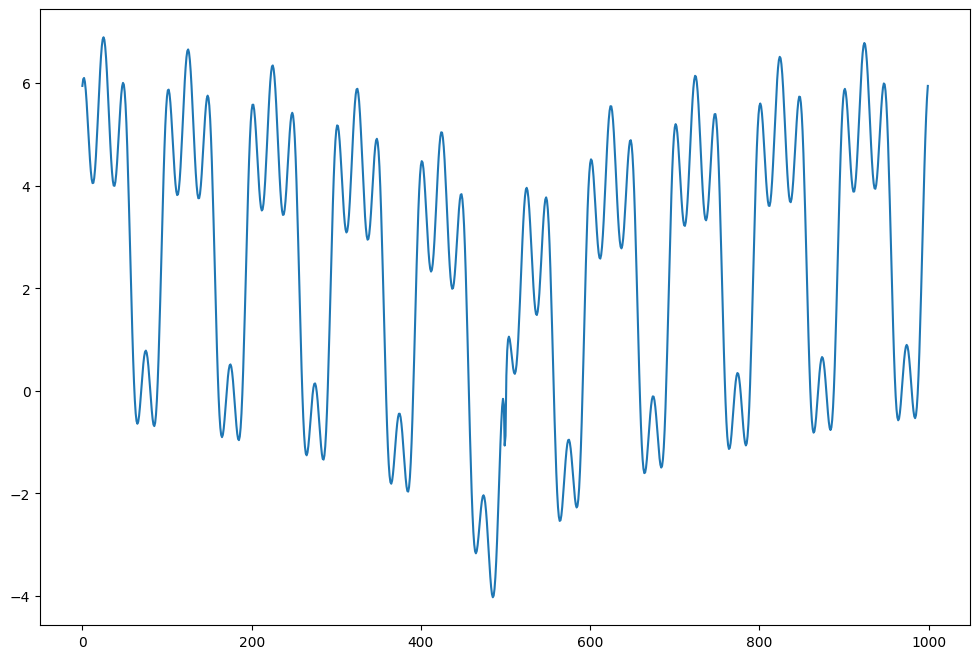

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(X)

Tanítás elindítása:

In [ ]:
window_size = 20
targets, preds = evaluate_timeseries(X, window_size)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 16, 4)               │              24 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 8, 4)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 4, 4)                │              84 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 2, 4)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 8)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 117 (468.00 B)

 Trainable params: 117 (468.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
44/44 - 8s - 177ms/step - loss: 10.4199 - mae: 2.7753 - val_loss: 11.2319 - val_mae: 2.8991
Epoch 2/50
44/44 - 0s - 5ms/step - loss: 7.3574 - mae: 2.3453 - val_loss: 6.5949 - val_mae: 2.2312
Epoch 3/50
44/44 - 0s - 6ms/step - loss: 5.1483 - mae: 1.8757 - val_loss: 5.1338 - val_mae: 1.8359
Epoch 4/50
44/44 - 0s - 5ms/step - loss: 4.5857 - mae: 1.7249 - val_loss: 4.8656 - val_mae: 1.7794
Epoch 5/50
44/44 - 0s - 5ms/step - loss: 4.1639 - mae: 1.6334 - val_loss: 4.5364 - val_mae: 1.7178
Epoch 6/50
44/44 - 0s - 6ms/step - loss: 3.6876 - mae: 1.5268 - val_loss: 4.0591 - val_mae: 1.6213
Epoch 7/50
44/44 - 0s - 6ms/step - loss: 3.2427 - mae: 1.4344 - val_loss: 3.5507 - val_mae: 1.5274
Epoch 8/50
44/44 - 0s - 6ms/step - loss: 2.8029 - mae: 1.3265 - val_loss: 3.0889 - val_mae: 1.4330
Epoch 9/50
44/44 - 0s - 7ms/step - loss: 2.4155 - mae: 1.2403 - val_loss: 2.6024 - val_mae: 1.3145
Epoch 10/50
44/44 - 1s - 13ms/step - loss: 2.0353 - mae: 1.1369 - val_loss: 2.1070 - val_mae: 1.1650
Epoc

Végül megjelenítjük a predikciót és az eredeti értékeket.

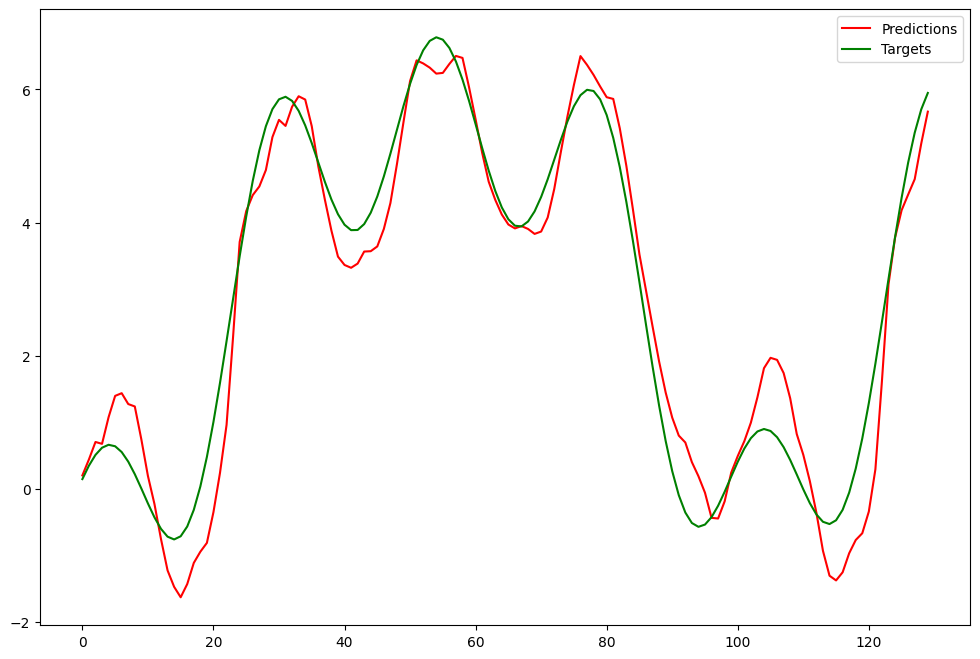

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(preds, color='r', label="Predictions")
plt.plot(targets, color='g', label="Targets")
plt.legend()